# IPCC Tier 1 method LB (Living Biomass) increase simulation for afferestation on cropland and grassland (CWS-Version)

In this example notebook the impact on the LB for a certain prototype configuration will be calculated and visualized.
This notebook is developed in such a way, that that user can play around with different configurations and analyze the outcome.

The **IPCC** layers and and needed LUT tables will be used in the first place to enable this simulation

#### Load and (install) used packages

In [4]:
import os
import glob
from pathlib import Path
import geopandas as gpd
from loguru import logger
from pathlib import Path, WindowsPath
import geopandas as gpd
import sys
import matplotlib.pyplot as plt
import logging
import rasterio
import rasterio.mask
import numpy as np
from osgeo import gdal
import subprocess
from osgeo import osr
import pandas as pd
import pprint
import datetime
import pyodbc 
import sqlalchemy as sa
from sqlalchemy import create_engine, event
from sqlalchemy.engine.url import URL
import json
now = datetime.datetime.now()


print ("STEP_01 libs loaded" + '  ' + str(now))

STEP_01 libs loaded  2023-09-07 09:57:11.736808


#### Load defined variables and functions

In [5]:
### location of the code to run the scenarios
sys.path.append(WindowsPath(os.getcwd()).parent.parent.joinpath('src'))
sys.path.append(Path(os.getcwd()).parent.parent.joinpath('src').as_posix())
from SOC_scenarios.utils.soc_helper_functions import *
from CWS.utils.cws_helper_functions import *
from constants import (type_method, dict_C_pool_mng_options, dir_signature )
from Biomass.utils.biom_helper_functions import *
from SOC.SOC_stratification import SOC_strat_IPCC_block_proc
from Biomass.run_afforestation_scenario import afforestation_LUT_block_proc

logger.add("../../.log/loguru.log")

print ("STEP_02 variables and functions loaded"+ '  ' + str(now))

STEP_02 variables and functions loaded  2023-09-07 09:57:11.736808


Load NUTS3 list:

In [19]:
nuts3_working_list =('AL011',	'AL012',	'AL013',	'AL014',	'AL015',	'AL021',	'AL022',	'AL031',	'AL032',	'AL033',	'AL034',	'AL035',	'AT111',	'AT112',	'AT113',	'AT121',	'AT122',	'AT123',	'AT124',	'AT125',	'AT126',	'AT127',	'AT130',	'AT211',	'AT212',	'AT213',	'AT221',	'AT222',	'AT223',	'AT224',	'AT225',	'AT226',	'AT311',	'AT312',	'AT313',	'AT314',	'AT315',	'AT321',	'AT322',	'AT323',	'AT331',	'AT332',	'AT333',	'AT334',	'AT335',	'AT341',	'AT342',	'BE100',	'BE211',	'BE212',	'BE213',	'BE223',	'BE224',	'BE225',	'BE231',	'BE232',	'BE233',	'BE234',	'BE235',	'BE236',	'BE241',	'BE242',	'BE251',	'BE252',	'BE253',	'BE254',	'BE255',	'BE256',	'BE257',	'BE258',	'BE310',	'BE323',	'BE328',	'BE329',	'BE32A',	'BE32B',	'BE32C',	'BE32D',	'BE331',	'BE332',	'BE334',	'BE335',	'BE336',	'BE341',	'BE342',	'BE343',	'BE344',	'BE345',	'BE351',	'BE352',	'BE353',	'BG311',	'BG312',	'BG313',	'BG314',	'BG315',	'BG321',	'BG322',	'BG323',	'BG324',	'BG325',	'BG331',	'BG332',	'BG333',	'BG334',	'BG341',	'BG342',	'BG343',	'BG344',	'BG411',	'BG412',	'BG413',	'BG414',	'BG415',	'BG421',	'BG422',	'BG423',	'BG424',	'BG425',	'CH011',	'CH012',	'CH013',	'CH021',	'CH022',	'CH023',	'CH024',	'CH025',	'CH031',	'CH032',	'CH033',	'CH040',	'CH051',	'CH052',	'CH053',	'CH054',	'CH055',	'CH056',	'CH057',	'CH061',	'CH062',	'CH063',	'CH064',	'CH065',	'CH066',	'CH070',	'CY000',	'CZ010',	'CZ020',	'CZ031',	'CZ032',	'CZ041',	'CZ042',	'CZ051',	'CZ052',	'CZ053',	'CZ063',	'CZ064',	'CZ071',	'CZ072',	'CZ080',	'DE111',	'DE112',	'DE113',	'DE114',	'DE115',	'DE116',	'DE117',	'DE118',	'DE119',	'DE11A',	'DE11B',	'DE11C',	'DE11D',	'DE121',	'DE122',	'DE123',	'DE124',	'DE125',	'DE126',	'DE127',	'DE128',	'DE129',	'DE12A',	'DE12B',	'DE12C',	'DE131',	'DE132',	'DE133',	'DE134',	'DE135',	'DE136',	'DE137',	'DE138',	'DE139',	'DE13A',	'DE141',	'DE142',	'DE143',	'DE144',	'DE145',	'DE146',	'DE147',	'DE148',	'DE149',	'DE211',	'DE212',	'DE213',	'DE214',	'DE215',	'DE216',	'DE217',	'DE218',	'DE219',	'DE21A',	'DE21B',	'DE21C',	'DE21D',	'DE21E',	'DE21F',	'DE21G',	'DE21H',	'DE21I',	'DE21J',	'DE21K',	'DE21L',	'DE21M',	'DE21N',	'DE221',	'DE222',	'DE223',	'DE224',	'DE225',	'DE226',	'DE227',	'DE228',	'DE229',	'DE22A',	'DE22B',	'DE22C',	'DE231',	'DE232',	'DE233',	'DE234',	'DE235',	'DE236',	'DE237',	'DE238',	'DE239',	'DE23A',	'DE241',	'DE242',	'DE243',	'DE244',	'DE245',	'DE246',	'DE247',	'DE248',	'DE249',	'DE24A',	'DE24B',	'DE24C',	'DE24D',	'DE251',	'DE252',	'DE253',	'DE254',	'DE255',	'DE256',	'DE257',	'DE258',	'DE259',	'DE25A',	'DE25B',	'DE25C',	'DE261',	'DE262',	'DE263',	'DE264',	'DE265',	'DE266',	'DE267',	'DE268',	'DE269',	'DE26A',	'DE26B',	'DE26C',	'DE271',	'DE272',	'DE273',	'DE274',	'DE275',	'DE276',	'DE277',	'DE278',	'DE279',	'DE27A',	'DE27B',	'DE27C',	'DE27D',	'DE27E',	'DE300',	'DE401',	'DE402',	'DE403',	'DE404',	'DE405',	'DE406',	'DE407',	'DE408',	'DE409',	'DE40A',	'DE40B',	'DE40C',	'DE40D',	'DE40E',	'DE40F',	'DE40G',	'DE40H',	'DE40I',	'DE501',	'DE502',	'DE600',	'DE711',	'DE712',	'DE713',	'DE714',	'DE715',	'DE716',	'DE717',	'DE718',	'DE719',	'DE71A',	'DE71B',	'DE71C',	'DE71D',	'DE71E',	'DE721',	'DE722',	'DE723',	'DE724',	'DE725',	'DE731',	'DE732',	'DE733',	'DE734',	'DE735',	'DE736',	'DE737',	'DE803',	'DE804',	'DE80J',	'DE80K',	'DE80L',	'DE80M',	'DE80N',	'DE80O',	'DE911',	'DE912',	'DE913',	'DE914',	'DE916',	'DE917',	'DE918',	'DE91A',	'DE91B',	'DE91C',	'DE922',	'DE923',	'DE925',	'DE926',	'DE927',	'DE928',	'DE929',	'DE931',	'DE932',	'DE933',	'DE934',	'DE935',	'DE936',	'DE937',	'DE938',	'DE939',	'DE93A',	'DE93B',	'DE941',	'DE942',	'DE943',	'DE944',	'DE945',	'DE946',	'DE947',	'DE948',	'DE949',	'DE94A',	'DE94B',	'DE94C',	'DE94D',	'DE94E',	'DE94F',	'DE94G',	'DE94H',	'DEA11',	'DEA12',	'DEA13',	'DEA14',	'DEA15',	'DEA16',	'DEA17',	'DEA18',	'DEA19',	'DEA1A',	'DEA1B',	'DEA1C',	'DEA1D',	'DEA1E',	'DEA1F',	'DEA22',	'DEA23',	'DEA24',	'DEA26',	'DEA27',	'DEA28',	'DEA29',	'DEA2A',	'DEA2B',	'DEA2C',	'DEA2D',	'DEA31',	'DEA32',	'DEA33',	'DEA34',	'DEA35',	'DEA36',	'DEA37',	'DEA38',	'DEA41',	'DEA42',	'DEA43',	'DEA44',	'DEA45',	'DEA46',	'DEA47',	'DEA51',	'DEA52',	'DEA53',	'DEA54',	'DEA55',	'DEA56',	'DEA57',	'DEA58',	'DEA59',	'DEA5A',	'DEA5B',	'DEA5C',	'DEB11',	'DEB12',	'DEB13',	'DEB14',	'DEB15',	'DEB17',	'DEB18',	'DEB1A',	'DEB1B',	'DEB1C',	'DEB1D',	'DEB21',	'DEB22',	'DEB23',	'DEB24',	'DEB25',	'DEB31',	'DEB32',	'DEB33',	'DEB34',	'DEB35',	'DEB36',	'DEB37',	'DEB38',	'DEB39',	'DEB3A',	'DEB3B',	'DEB3C',	'DEB3D',	'DEB3E',	'DEB3F',	'DEB3G',	'DEB3H',	'DEB3I',	'DEB3J',	'DEB3K',	'37226',	'37591',	'37956',	'38322',	'38687',	'39052',	'DED21',	'DED2C',	'DED2D',	'DED2E',	'DED2F',	'DED41',	'DED42',	'DED43',	'DED44',	'DED45',	'DED51',	'DED52',	'DED53',	'DEE01',	'DEE02',	'DEE03',	'DEE04',	'DEE05',	'DEE06',	'DEE07',	'DEE08',	'DEE09',	'DEE0A',	'DEE0B',	'DEE0C',	'DEE0D',	'DEE0E',	'DEF01',	'DEF02',	'DEF03',	'DEF04',	'DEF05',	'DEF06',	'DEF07',	'DEF08',	'DEF09',	'DEF0A',	'DEF0B',	'DEF0C',	'DEF0D',	'DEF0E',	'DEF0F',	'DEG01',	'DEG02',	'DEG03',	'DEG04',	'DEG05',	'DEG06',	'DEG07',	'DEG09',	'DEG0A',	'DEG0B',	'DEG0C',	'DEG0D',	'DEG0E',	'DEG0F',	'DEG0G',	'DEG0H',	'DEG0I',	'DEG0J',	'DEG0K',	'DEG0L',	'DEG0M',	'DEG0N',	'DEG0P',	'DK011',	'DK012',	'DK013',	'DK014',	'DK021',	'DK022',	'DK031',	'DK032',	'DK041',	'DK042',	'DK050',	'EE001',	'EE004',	'EE008',	'EE009',	'EE00A',	'EL301',	'EL302',	'EL303',	'EL304',	'EL305',	'EL306',	'EL307',	'EL411',	'EL412',	'EL413',	'EL421',	'EL422',	'EL431',	'EL432',	'EL433',	'EL434',	'EL511',	'EL512',	'EL513',	'EL514',	'EL515',	'EL521',	'EL522',	'EL523',	'EL524',	'EL525',	'EL526',	'EL527',	'EL531',	'EL532',	'EL533',	'EL541',	'EL542',	'EL543',	'EL611',	'EL612',	'EL613',	'EL621',	'EL622',	'EL623',	'EL624',	'EL631',	'EL632',	'EL633',	'EL641',	'EL642',	'EL643',	'EL644',	'EL645',	'EL651',	'EL652',	'EL653',	'ES111',	'ES112',	'ES113',	'ES114',	'ES120',	'ES130',	'ES211',	'ES212',	'ES213',	'ES220',	'ES230',	'ES241',	'ES242',	'ES243',	'ES300',	'ES411',	'ES412',	'ES413',	'ES414',	'ES415',	'ES416',	'ES417',	'ES418',	'ES419',	'ES421',	'ES422',	'ES423',	'ES424',	'ES425',	'ES431',	'ES432',	'ES511',	'ES512',	'ES513',	'ES514',	'ES521',	'ES522',	'ES523',	'ES531',	'ES532',	'ES533',	'ES611',	'ES612',	'ES613',	'ES614',	'ES615',	'ES616',	'ES617',	'ES618',	'ES620',	'ES630',	'ES640',	'ES703',	'ES704',	'ES705',	'ES706',	'ES707',	'ES708',	'ES709',	'FI193',	'FI194',	'FI195',	'FI196',	'FI197',	'FI1B1',	'FI1C1',	'FI1C2',	'FI1C3',	'FI1C4',	'FI1C5',	'FI1D1',	'FI1D2',	'FI1D3',	'FI1D5',	'FI1D7',	'FI1D8',	'FI1D9',	'FI200',	'FR101',	'FR102',	'FR103',	'FR104',	'FR105',	'FR106',	'FR107',	'FR108',	'FRB01',	'FRB02',	'FRB03',	'FRB04',	'FRB05',	'FRB06',	'FRC11',	'FRC12',	'FRC13',	'FRC14',	'FRC21',	'FRC22',	'FRC23',	'FRC24',	'FRD11',	'FRD12',	'FRD13',	'FRD21',	'FRD22',	'FRE11',	'FRE12',	'FRE21',	'FRE22',	'FRE23',	'FRF11',	'FRF12',	'FRF21',	'FRF22',	'FRF23',	'FRF24',	'FRF31',	'FRF32',	'FRF33',	'FRF34',	'FRG01',	'FRG02',	'FRG03',	'FRG04',	'FRG05',	'FRH01',	'FRH02',	'FRH03',	'FRH04',	'FRI11',	'FRI12',	'FRI13',	'FRI14',	'FRI15',	'FRI21',	'FRI22',	'FRI23',	'FRI31',	'FRI32',	'FRI33',	'FRI34',	'FRJ11',	'FRJ12',	'FRJ13',	'FRJ14',	'FRJ15',	'FRJ21',	'FRJ22',	'FRJ23',	'FRJ24',	'FRJ25',	'FRJ26',	'FRJ27',	'FRJ28',	'FRK11',	'FRK12',	'FRK13',	'FRK14',	'FRK21',	'FRK22',	'FRK23',	'FRK24',	'FRK25',	'FRK26',	'FRK27',	'FRK28',	'FRL01',	'FRL02',	'FRL03',	'FRL04',	'FRL05',	'FRL06',	'FRM01',	'FRM02',	'HR021',	'HR022',	'HR023',	'HR024',	'HR025',	'HR026',	'HR027',	'HR028',	'HR031',	'HR032',	'HR033',	'HR034',	'HR035',	'HR036',	'HR037',	'HR050',	'HR061',	'HR062',	'HR063',	'HR064',	'HR065',	'HU110',	'HU120',	'HU211',	'HU212',	'HU213',	'HU221',	'HU222',	'HU223',	'HU231',	'HU232',	'HU233',	'HU311',	'HU312',	'HU313',	'HU321',	'HU322',	'HU323',	'HU331',	'HU332',	'HU333',	'IE041',	'IE042',	'IE051',	'IE052',	'IE053',	'IE061',	'IE062',	'IE063',	'IS001',	'IS002',	'ITC11',	'ITC12',	'ITC13',	'ITC14',	'ITC15',	'ITC16',	'ITC17',	'ITC18',	'ITC20',	'ITC31',	'ITC32',	'ITC33',	'ITC34',	'ITC41',	'ITC42',	'ITC43',	'ITC44',	'ITC46',	'ITC47',	'ITC48',	'ITC49',	'ITC4A',	'ITC4B',	'ITC4C',	'ITC4D',	'ITF11',	'ITF12',	'ITF13',	'ITF14',	'ITF21',	'ITF22',	'ITF31',	'ITF32',	'ITF33',	'ITF34',	'ITF35',	'ITF43',	'ITF44',	'ITF45',	'ITF46',	'ITF47',	'ITF48',	'ITF51',	'ITF52',	'ITF61',	'ITF62',	'ITF63',	'ITF64',	'ITF65',	'ITG11',	'ITG12',	'ITG13',	'ITG14',	'ITG15',	'ITG16',	'ITG17',	'ITG18',	'ITG19',	'ITG2D',	'ITG2E',	'ITG2F',	'ITG2G',	'ITG2H',	'ITH10',	'ITH20',	'ITH31',	'ITH32',	'ITH33',	'ITH34',	'ITH35',	'ITH36',	'ITH37',	'ITH41',	'ITH42',	'ITH43',	'ITH44',	'ITH51',	'ITH52',	'ITH53',	'ITH54',	'ITH55',	'ITH56',	'ITH57',	'ITH58',	'ITH59',	'ITI11',	'ITI12',	'ITI13',	'ITI14',	'ITI15',	'ITI16',	'ITI17',	'ITI18',	'ITI19',	'ITI1A',	'ITI21',	'ITI22',	'ITI31',	'ITI32',	'ITI33',	'ITI34',	'ITI35',	'ITI41',	'ITI42',	'ITI43',	'ITI44',	'ITI45',	'LI000',	'LT011',	'LT021',	'LT022',	'LT023',	'LT024',	'LT025',	'LT026',	'LT027',	'LT028',	'LT029',	'LU000',	'LV003',	'LV005',	'LV006',	'LV007',	'LV008',	'LV009',	'ME000',	'MK001',	'MK002',	'MK003',	'MK004',	'MK005',	'MK006',	'MK007',	'MK008',	'MT001',	'MT002',	'NL111',	'NL112',	'NL113',	'NL124',	'NL125',	'NL126',	'NL131',	'NL132',	'NL133',	'NL211',	'NL212',	'NL213',	'NL221',	'NL224',	'NL225',	'NL226',	'NL230',	'NL310',	'NL321',	'NL323',	'NL324',	'NL325',	'NL327',	'NL328',	'NL329',	'NL332',	'NL333',	'NL337',	'NL33A',	'NL33B',	'NL33C',	'NL341',	'NL342',	'NL411',	'NL412',	'NL413',	'NL414',	'NL421',	'NL422',	'NL423',	'NO020',	'NO060',	'NO071',	'NO074',	'NO081',	'NO082',	'NO091',	'NO092',	'NO0A1',	'NO0A2',	'NO0A3',	'NO0B1',	'NO0B2',	'PL213',	'PL214',	'PL217',	'PL218',	'PL219',	'PL21A',	'PL224',	'PL225',	'PL227',	'PL228',	'PL229',	'PL22A',	'PL22B',	'PL22C',	'PL411',	'PL414',	'PL415',	'PL416',	'PL417',	'PL418',	'PL424',	'PL426',	'PL427',	'PL428',	'PL431',	'PL432',	'PL514',	'PL515',	'PL516',	'PL517',	'PL518',	'PL523',	'PL524',	'PL613',	'PL616',	'PL617',	'PL618',	'PL619',	'PL621',	'PL622',	'PL623',	'PL633',	'PL634',	'PL636',	'PL637',	'PL638',	'PL711',	'PL712',	'PL713',	'PL714',	'PL715',	'PL721',	'PL722',	'PL811',	'PL812',	'PL814',	'PL815',	'PL821',	'PL822',	'PL823',	'PL824',	'PL841',	'PL842',	'PL843',	'PL911',	'PL912',	'PL913',	'PL921',	'PL922',	'PL923',	'PL924',	'PL925',	'PL926',	'PT111',	'PT112',	'PT119',	'PT11A',	'PT11B',	'PT11C',	'PT11D',	'PT11E',	'PT150',	'PT16B',	'PT16D',	'PT16E',	'PT16F',	'PT16G',	'PT16H',	'PT16I',	'PT16J',	'PT170',	'PT181',	'PT184',	'PT185',	'PT186',	'PT187',	'PT200',	'PT300',	'RO111',	'RO112',	'RO113',	'RO114',	'RO115',	'RO116',	'RO121',	'RO122',	'RO123',	'RO124',	'RO125',	'RO126',	'RO211',	'RO212',	'RO213',	'RO214',	'RO215',	'RO216',	'RO221',	'RO222',	'RO223',	'RO224',	'RO225',	'RO226',	'RO311',	'RO312',	'RO313',	'RO314',	'RO315',	'RO316',	'RO317',	'RO321',	'RO322',	'RO411',	'RO412',	'RO413',	'RO414',	'RO415',	'RO421',	'RO422',	'RO423',	'RO424',	'RS110',	'RS121',	'RS122',	'RS123',	'RS124',	'RS125',	'RS126',	'RS127',	'RS211',	'RS212',	'RS213',	'RS214',	'RS215',	'RS216',	'RS217',	'RS218',	'RS221',	'RS222',	'RS223',	'RS224',	'RS225',	'RS226',	'RS227',	'RS228',	'RS229',	'SE110',	'SE121',	'SE122',	'SE123',	'SE124',	'SE125',	'SE211',	'SE212',	'SE213',	'SE214',	'SE221',	'SE224',	'SE231',	'SE232',	'SE311',	'SE312',	'SE313',	'SE321',	'SE322',	'SE331',	'SE332',	'SI031',	'SI032',	'SI033',	'SI034',	'SI035',	'SI036',	'SI037',	'SI038',	'SI041',	'SI042',	'SI043',	'SI044',	'SK010',	'SK021',	'SK022',	'SK023',	'SK031',	'SK032',	'SK041',	'SK042',	'TR100',	'TR211',	'TR212',	'TR213',	'TR221',	'TR222',	'TR310',	'TR321',	'TR322',	'TR323',	'TR331',	'TR332',	'TR333',	'TR334',	'TR411',	'TR412',	'TR413',	'TR421',	'TR422',	'TR423',	'TR424',	'TR425',	'TR510',	'TR521',	'TR522',	'TR611',	'TR612',	'TR613',	'TR621',	'TR622',	'TR631',	'TR632',	'TR633',	'TR711',	'TR712',	'TR713',	'TR714',	'TR715',	'TR721',	'TR722',	'TR723',	'TR811',	'TR812',	'TR813',	'TR821',	'TR822',	'TR823',	'TR831',	'TR832',	'TR833',	'TR834',	'TR901',	'TR902',	'TR903',	'TR904',	'TR905',	'TR906',	'TRA11',	'TRA12',	'TRA13',	'TRA21',	'TRA22',	'TRA23',	'TRA24',	'TRB11',	'TRB12',	'TRB13',	'TRB14',	'TRB21',	'TRB22',	'TRB23',	'TRB24',	'TRC11',	'TRC12',	'TRC13',	'TRC21',	'TRC22',	'TRC31',	'TRC32',	'TRC33',	'TRC34',	'UKC11',	'UKC12',	'UKC13',	'UKC14',	'UKC21',	'UKC22',	'UKC23',	'UKD11',	'UKD12',	'UKD33',	'UKD34',	'UKD35',	'UKD36',	'UKD37',	'UKD41',	'UKD42',	'UKD44',	'UKD45',	'UKD46',	'UKD47',	'UKD61',	'UKD62',	'UKD63',	'UKD71',	'UKD72',	'UKD73',	'UKD74',	'UKE11',	'UKE12',	'UKE13',	'UKE21',	'UKE22',	'UKE31',	'UKE32',	'UKE41',	'UKE42',	'UKE44',	'UKE45',	'UKF11',	'UKF12',	'UKF13',	'UKF14',	'UKF15',	'UKF16',	'UKF21',	'UKF22',	'UKF24',	'UKF25',	'UKF30',	'UKG11',	'UKG12',	'UKG13',	'UKG21',	'UKG22',	'UKG23',	'UKG24',	'UKG31',	'UKG32',	'UKG33',	'UKG36',	'UKG37',	'UKG38',	'UKG39',	'UKH11',	'UKH12',	'UKH14',	'UKH15',	'UKH16',	'UKH17',	'UKH21',	'UKH23',	'UKH24',	'UKH25',	'UKH31',	'UKH32',	'UKH34',	'UKH35',	'UKH36',	'UKH37',	'UKI31',	'UKI32',	'UKI33',	'UKI34',	'UKI41',	'UKI42',	'UKI43',	'UKI44',	'UKI45',	'UKI51',	'UKI52',	'UKI53',	'UKI54',	'UKI61',	'UKI62',	'UKI63',	'UKI71',	'UKI72',	'UKI73',	'UKI74',	'UKI75',	'UKJ11',	'UKJ12',	'UKJ13',	'UKJ14',	'UKJ21',	'UKJ22',	'UKJ25',	'UKJ26',	'UKJ27',	'UKJ28',	'UKJ31',	'UKJ32',	'UKJ34',	'UKJ35',	'UKJ36',	'UKJ37',	'UKJ41',	'UKJ43',	'UKJ44',	'UKJ45',	'UKJ46',	'UKK11',	'UKK12',	'UKK13',	'UKK14',	'UKK15',	'UKK23',	'UKK24',	'UKK25',	'UKK30',	'UKK41',	'UKK42',	'UKK43',	'UKL11',	'UKL12',	'UKL13',	'UKL14',	'UKL15',	'UKL16',	'UKL17',	'UKL18',	'UKL21',	'UKL22',	'UKL23',	'UKL24',	'UKM50',	'UKM61',	'UKM62',	'UKM63',	'UKM64',	'UKM65',	'UKM66',	'UKM71',	'UKM72',	'UKM73',	'UKM75',	'UKM76',	'UKM77',	'UKM78',	'UKM81',	'UKM82',	'UKM83',	'UKM84',	'UKM91',	'UKM92',	'UKM93',	'UKM94',	'UKM95',	'UKN06',	'UKN07',	'UKN08',	'UKN09',	'UKN0A',	'UKN0B',	'UKN0C',	'UKN0D',	'UKN0E',	'UKN0F',	'UKN0G')
for nuts in nuts3_working_list:
    print (nuts)

AL011
AL012
AL013
AL014
AL015
AL021
AL022
AL031
AL032
AL033
AL034
AL035
AT111
AT112
AT113
AT121
AT122
AT123
AT124
AT125
AT126
AT127
AT130
AT211
AT212
AT213
AT221
AT222
AT223
AT224
AT225
AT226
AT311
AT312
AT313
AT314
AT315
AT321
AT322
AT323
AT331
AT332
AT333
AT334
AT335
AT341
AT342
BE100
BE211
BE212
BE213
BE223
BE224
BE225
BE231
BE232
BE233
BE234
BE235
BE236
BE241
BE242
BE251
BE252
BE253
BE254
BE255
BE256
BE257
BE258
BE310
BE323
BE328
BE329
BE32A
BE32B
BE32C
BE32D
BE331
BE332
BE334
BE335
BE336
BE341
BE342
BE343
BE344
BE345
BE351
BE352
BE353
BG311
BG312
BG313
BG314
BG315
BG321
BG322
BG323
BG324
BG325
BG331
BG332
BG333
BG334
BG341
BG342
BG343
BG344
BG411
BG412
BG413
BG414
BG415
BG421
BG422
BG423
BG424
BG425
CH011
CH012
CH013
CH021
CH022
CH023
CH024
CH025
CH031
CH032
CH033
CH040
CH051
CH052
CH053
CH054
CH055
CH056
CH057
CH061
CH062
CH063
CH064
CH065
CH066
CH070
CY000
CZ010
CZ020
CZ031
CZ032
CZ041
CZ042
CZ051
CZ052
CZ053
CZ063
CZ064
CZ071
CZ072
CZ080
DE111
DE112
DE113
DE114
DE115
DE116
DE11

#### IPCC LB calculation when afforesation part of the cropland and grassland

The IPCC Tier-1 formula listed below forms the basis of this living biomass increase calculation a for certain tree species. The formula is retrieved from the following IPCC document (pg.15) : https://www.ipcc-nggip.iges.or.jp/public/2006gl/pdf/4_Volume4/V4_02_Ch2_Generic.pdf 

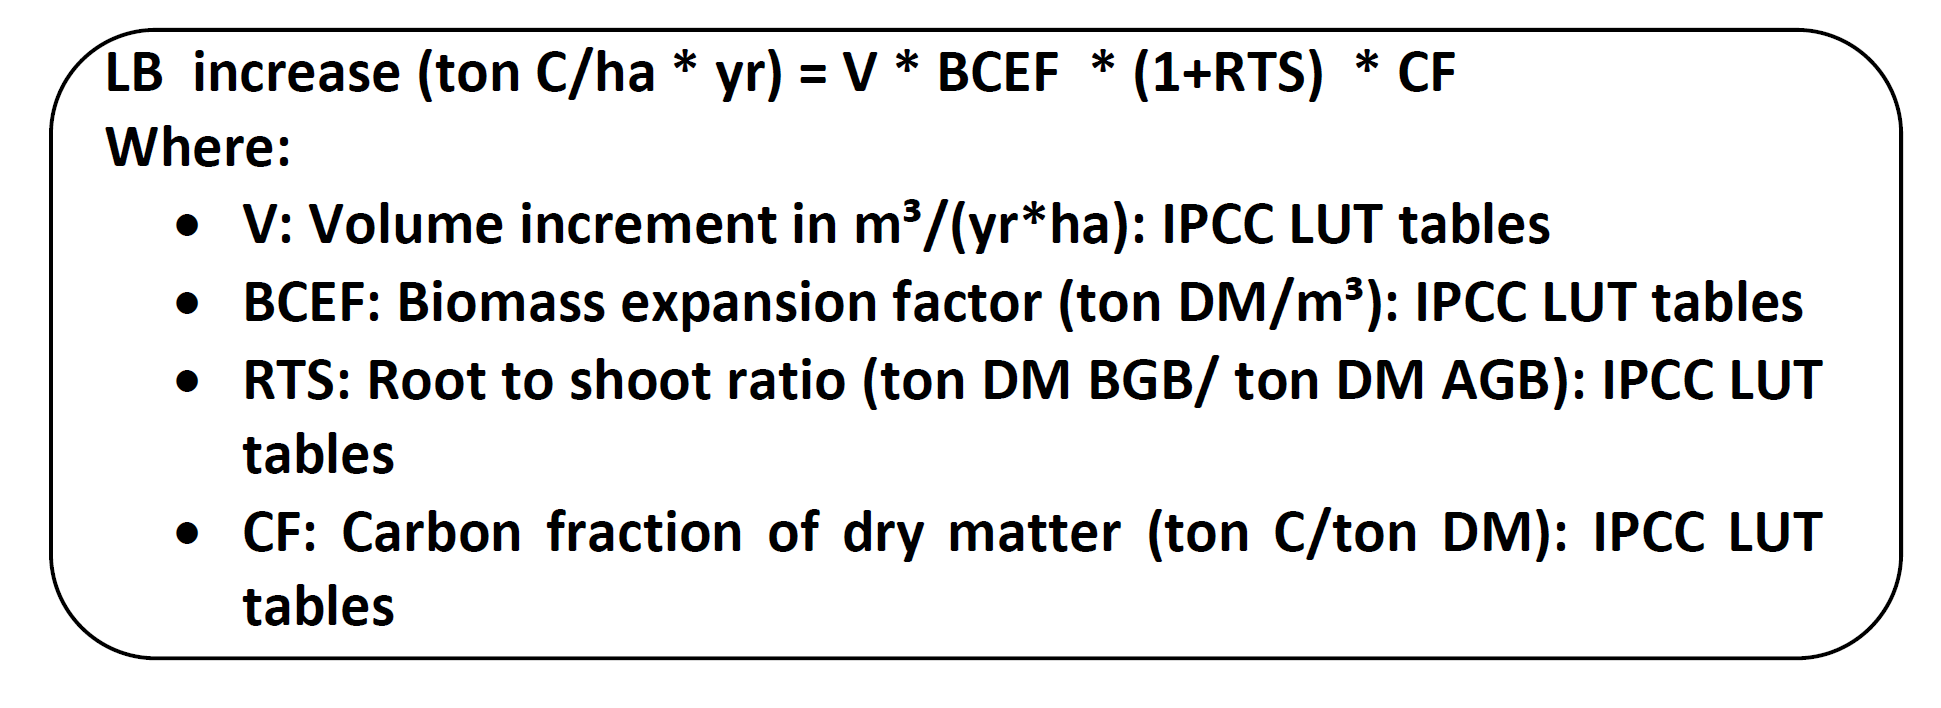
<br>

Only the volume increment is made flexible in the first prototype and can be derived from the IPCC LUT that relates a tree species to a certain volume increment <br>

## PART1: CONFIGURE AFFORESTATION SCENARIO

### Options for configuration of afforestation scenario

Define the configuration for the flexible parameters that will determine the afforestation scenario


#### Slope

Threshold on slope for afforestation. Slopes above the defined threshold will be used for afforesation. Options between 0-87.5 (%)

#### RCP

The emission scenario of the EUTrees4F that will be used for the future occurrence probability of a certain tree species. Default take the 'rcp45' scenario

#### Tree_prob
The probability of occurrence that a certain tree species should have in a certain target year before it can be used for afforestation. Options between 0-100 (%)

#### Tree_species

The tree species you want to use for the afforestation. Current options for which IPCC volume increment information is available:

* **Fagus_sylvatica** <br>

* **Larix_decidua** <br>

* **Picea_abies** <br>

* **Pinus_pinaster** <br>

* **Pinus_sylvestris** <br>

* **Quercus_robur** <br>


#### Perc_reforest

The percentage of suitable (determined by the afforestation mask) grassland/cropland that should be afforested. Options between 0-100 (%)

#### Year_potential
The target year for which the afforestation carbon sequestration potential calculation should be done (2019 -...)

#### Year_baseline
The baseline year for which the afforestation carbon sequestration potential calculation should start and thus the year at which the trees will be planted


#### lst_CLC_afforestation
Define which CLC classes can be used for afforestation
Based on the column 'Afforestation_mask' from CLC_LULUCF table: https://eea1.sharepoint.com/:x:/r/teams/-EXT-CrossETCexchange/_layouts/15/Doc.aspx?sourcedoc=%7B447d1502-9f54-43e2-900a-14a239770769%7D&action=edit&wdLOR=cAE9313DD-6E50-40F6-A328-F1101ABF05EE&activeCell=%27CLC_LULUCF_LUT%27!G30&wdinitialsession=73a03156-95ab-4412-8a03-e3ccd81233d7&wdrldsc=2&wdrldc=1&wdrldr=AccessTokenExpiredWarning%2CRefreshingExpiredAccessT&cid=16243ca6-b7d4-411f-9dd8-924b725e256a



<br> The use of **NUTS specific** factors can be enabled by setting the parameter **'run_NUTS_specific_scenario' on True**.
<br> Please be aware that in that case a LUT should be established which assign a specific configuration to each NUTS region. 
<br> Currently, a randomly defined configuration in the data folder 'NUTS_LUT_afforestation_scenario' will be loaded. 


#### First prototype configuration:

This is the initial configuration that was used to generate the afforestation maps <br>

'Slope': 0, <br>
'RCP': 'rcp45', <br>
'Tree_prob': 70, <br>
'Tree_species': 'Quercus_robur', <br>
'Perc_reforest': 10, <br>
'Year_potential': 2035, <br>
'input_source': 'EEA39'} <br>

   
the input_source parameter just indicates that this is the default configuration at EEA39 scale. If a NUTS specific scenario is enabled this will be set to the NUTS level for which this parameter is defined.

In [91]:


# Reading from input parameter for scenarios...TESTING TESTINMG
with open('../../config/afforestation_scenarios_parameters.json') as file:
   data = json.load(file)
#print(data)
for scenario in data["scenarios"]:
        print("---")
        scenario_name=        scenario["name"]
        scenario_Slope=       scenario["Slope"]
        scenario_Tree_prob = scenario["Tree_prob"]
        scenario_RCP=(scenario["RCP"])
        scenario_Tree_species=(scenario["Tree_species"])
        scenario_Perc_reforest=(scenario["Perc_reforest"])
        scenario_Year_potential=(scenario["Year_potential"])
        scenario_input_source=(scenario["input_source"])






---
---


In [7]:
## now this configuration will be put into a dictionary

Year_potential = 2035
Year_baseline = 2018

# define which management action is applied
mng_option = 'afforestation'

# load the carbon pool that is targeted here
carbon_pool = dict_C_pool_mng_options.get(mng_option)

# List of CLC classes (LEVEL-3) that can be used for afforestation
lst_CLC_afforestation = [211, 212, 213, 231]
import json
parameters = json.read(...)
parameters.afforestation_scenario_1
dict_default_afforestation_factors = {
        'Slope': 0,
        'RCP': 'rcp45',
        'Tree_prob': 70,
        'Tree_species': 'Quercus_robur',
        'Perc_reforest': 10,
        'Year_potential': Year_potential,
        'input_source': 'EEA39'}

SCENARIO_SPECS = {
        'mng_option': mng_option, 
        'Year_potential': Year_potential,
        'Year_baseline': Year_baseline,
        'carbon_pool': carbon_pool, # Living biomass pool
        'lst_CLC_affor': lst_CLC_afforestation,
        'afforestation_config': dict_default_afforestation_factors
    }

pprint.pprint(dict_default_afforestation_factors)
pprint.pprint(SCENARIO_SPECS)
print ("STEP_03 dictionary set up done"+ '  ' + str(now))

{'Perc_reforest': 10,
 'RCP': 'rcp45',
 'Slope': 0,
 'Tree_prob': 70,
 'Tree_species': 'Quercus_robur',
 'Year_potential': 2035,
 'input_source': 'EEA39'}
{'Year_baseline': 2018,
 'Year_potential': 2035,
 'afforestation_config': {'Perc_reforest': 10,
                          'RCP': 'rcp45',
                          'Slope': 0,
                          'Tree_prob': 70,
                          'Tree_species': 'Quercus_robur',
                          'Year_potential': 2035,
                          'input_source': 'EEA39'},
 'carbon_pool': 'LB',
 'lst_CLC_affor': [211, 212, 213, 231],
 'mng_option': 'afforestation'}
STEP_03 dictionary set up done  2023-09-07 09:57:11.736808


## PART2: CONFIGURE PROCESSING SETTINGS


In [8]:
# Define if the results should be created by block-based
# processing, meaning only the window for the AOI (i.e., NUTS region) will
# be loaded

# Only this type of processing is supported for the moment!!!
block_based_processing = True

# Country_running
Country = None  # set to None if want to run entire EEA39 extent 

# suffix of the output raster and ID that is
# used to distinguish different scenario runs
scenario_name = f'Scenario_1_{str(Year_potential)}_fix'

# if want to run with some NUTS specific factors
# set the below parameter to true
# if a country is defined only the NUTS regions
# in that country will be considered
run_NUTS_specific_scenario = False ## original FALSE


# Indicate if stats at NUTS LEVEL need to be provided
# this will be witten in shapefile format and saved
add_stats_NUTS_level = True


# define if the result might be overwritten
overwrite = False

# basefolder of input and output data
# TODO adapt to work also on Unix-like systems
basefolder = dir_signature

# the location of the basefolder in which all the input data needed for the simulation is provided
Basefolder_input_data = os.path.join(basefolder, 'input')

### the basefolder in which all the output results will be stored
Basefolder_output_data =  os.path.join(basefolder, 'output')
# TODO change if you want to save the data locally
# Basefolder_output_data =  os.path.join(os.getcwd(), 'output')

# the name of the drive on which all the data can be accessed:
# dir_signature = basefolder

# location where the NUTS specific configuration for afforesation is stored
NUTS_LUT_factors_folder = os.path.join(Basefolder_output_data,'NUTS_LUT_afforestation_scenario')


CONFIGURATION_SPECS = {
    'block_based_processing': block_based_processing,
    'Country': Country,
    'scenario_name': scenario_name,
    'run_NUTS_SPECIFIC': run_NUTS_specific_scenario,
    'add_stats_NUTS': add_stats_NUTS_level,
    'scaling': 100,
    'NUTS_LUT_folder': NUTS_LUT_factors_folder,
    'overwrite': overwrite,
    'dir_signature': dir_signature,
    'type_method': type_method,
    'Basefolder_output': Basefolder_output_data,
    'Basefolder_input': Basefolder_input_data
}

pprint.pprint(CONFIGURATION_SPECS)
print ("-------------------------------------------------")
print ("STEP_04 basefolder set and confi specifications done"+ '  ' + str(now))

{'Basefolder_input': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\input',
 'Basefolder_output': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\output',
 'Country': None,
 'NUTS_LUT_folder': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\output\\NUTS_LUT_afforestation_scenario',
 'add_stats_NUTS': True,
 'block_based_processing': True,
 'dir_signature': WindowsPath('//cwsfileserver/projects/lulucf/f02_data/carbon_model_data'),
 'overwrite': False,
 'run_NUTS_SPECIFIC': False,
 'scaling': 100,
 'scenario_name': 'Scenario_1_2035_fix',
 'type_method': 'LUT'}
-------------------------------------------------
STEP_04 basefolder set and confi specifications done  2023-09-07 09:57:11.736808


## PART3: DEFINE REQUIRED DATASETS

In [9]:
"""Load the datasets needed for running the scenario"""

# Define processing extent
## location with the EEA39 extent
EEA_extent_layer = gpd.read_file(os.path.join(Basefolder_input_data, 'AOI', 'EEA39_extent_noDOM.shp'))

VECTORS = {'NUTS':os.path.join(Basefolder_input_data, 'NUTS', 'NUTS_RG_20M_2021_3035.shp'),
           'EEA_extent': EEA_extent_layer}

"""Load the datasets needed for afforestation mask"""

# Below define the locations of the
# rasters needed for the afforestation mask

#### Below the paths to the files needed for the afforestation mask will be defined 
#DEM_location = os.path.join('/data', 'inca_vol1', 'input_data', 'wood_provision',
#                                'input_intermediate', 'DEM', 'dt1_slope_INCA_100m_EPSG3035.tif')
DEM_location = os.path.join(Basefolder_input_data, 'DEM', 'dt1_slope_INCA_100m_EPSG3035.tif')




#N2K_location = os.path.join('/data', 'inca_vol1', 'input_data', 'wood_provision',
#                                'input_intermediate', 'N2K', 'N2K_2018_100m.tif')
N2K_location = os.path.join(Basefolder_input_data, 'N2K', 'N2K_2018_100m.tif')

# if a region specific external mask is available,
# please insert it below otherwise set it to 'None'
# !! TODO Please ensure that all the rasters are on the same grid
external_mask = None


########## TODO: ETC/DI #############

"""
Following additional dtaatsets should be implemented to identify those areas 
that should be protected for afforestation:
* Nationally designated areas (CDDA): Protected areas should be EXCLUDED for afforestation
* High nature value farmland 2012: High nature value farmland should be EXCLUDED for afforestation
* Extended wetland layer (2018): Any wetland should be EXCLUDED for afforestation
* Peatland map (2017): Tanneberger peatland map --> peatland should be EXCLUDED for afforestation


The abandoned cropland locations should be PRIORITIZED for afforestation if is has been found suitable
for afforestation based on the afforestation mask
"""


CLC_dir = os.path.join(Basefolder_input_data, 'CLC_ACC', 'CLC2018ACC_V2018_20.tif')

DATASETS_afforestation = {'DEM': DEM_location,
                          'N2K': N2K_location,
                          'external_mask': external_mask,
                          'CLC': CLC_dir}

"""Load the datasets needed for defining afforestation suitability of tree species"""

# Below define the raster(s) for defining the suitability
#  of planting a certain tree species

## Load the basefolder of the EU4Trees dataset
EU4Trees_base = os.path.join(Basefolder_input_data, 'EU-Trees4F', 'ens_sdms','prob','resampled')

DATASETS_AFFORESTATION_SUITABILTY = {
    'EU4Trees': EU4Trees_base
}

"""Load IPCC datasets needed to assign strata specific increment values"""

# Put all the IPCC related datasets used for
# strata based assigned using the LUT

## the directory of the IPCC climate  
IPCC_climate_raster = os.path.join(Basefolder_input_data, 'IPCC_layers', 'climate', 'ipcc_climate_zone_100m_EPSG3035_EEA39.tif') 

DATASETS_IPCC = {
    'CLIMATE_ZONES': IPCC_climate_raster,
}

DATASETS_SPECS = {
    'VECTORS': VECTORS,
    'AFFORESTATION_MASK': DATASETS_afforestation,
    'AFFORESTATION_SUITABILITY': DATASETS_AFFORESTATION_SUITABILTY,
    'IPCC_STRATIFICATION': DATASETS_IPCC
}

pprint.pprint(DATASETS_SPECS)
print ("-------------------------------------------------")
print ("STEP_05 Load the datasets needed for running the scenario ...done"+ '  ' + str(now))


{'AFFORESTATION_MASK': {'CLC': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\input\\CLC_ACC\\CLC2018ACC_V2018_20.tif',
                        'DEM': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\input\\DEM\\dt1_slope_INCA_100m_EPSG3035.tif',
                        'N2K': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\input\\N2K\\N2K_2018_100m.tif',
                        'external_mask': None},
 'AFFORESTATION_SUITABILITY': {'EU4Trees': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\input\\EU-Trees4F\\ens_sdms\\prob\\resampled'},
 'IPCC_STRATIFICATION': {'CLIMATE_ZONES': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\input\\IPCC_layers\\climate\\ipcc_climate_zone_100m_EPSG3035_EEA39.tif'},
 'VECTORS': {'EEA_extent':                                            PopupInfo  Shape_Leng  Shape_Area  \
0  TILE PROPERTIES<br><table border=0 cellpadding...    4.522357    1.258132   

   Orign


## Specify area of interest
(running on the entire EEA39 extent is not recommended in a Notebook environment due to memory limitations!) 
NUTS based processing of entire extent is possible, but in that case the **'run_NUTS_specific_scenario'** parameter should be set to True.

A NUTS3 region should be selected for processing (e.g. 'PL432').The original script located here: https://github.com/VITObelgium/ETC-CCA-LULUCF/blob/master/Scripts/Biomass/run_afforestation_scenario.py  will allow to run all different NUTS regions at country or EU level at once. This notebook examplifies just the workflow for one NUTS region. 

## PART 10-LOOP Set up of an example loop over all NUTS regions and storing the results on greenmonky
(should be done in furuter with a script) 

In [15]:
###EXTRA BOX ..testing simple nuts3 loop:

print("START")

engine_greenmonkey = sa.create_engine('mssql+pyodbc://' + "GREENMONKEY" + '/' + "Carbon_Mapping" + '?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server')
# connection = engine_greenmonkey.raw_connection()
# cursor = connection.cursor()
# connection.commit()

# print ("Reading nuts3 table from greenmonkey")
# query=('''

#                 SELECT  
#                     [LEVEL3_NAM]
#                     ,[LEVEL3_COD]
#                 FROM [Carbon_Mapping].[LUT].[L_adm_eea39_2021LUT] where TAA in('Land area', 'Inland water')

#                 and   [LEVEL3_COD]  not in ('VA','KS','BA','AD','MC','SM','UK','ELZZZ')
#                 group by  [LEVEL3_NAM],[LEVEL3_COD]  order by [LEVEL3_COD]

#                 ''')

# df_nuts3_table = pd.read_sql(query, engine_greenmonkey)
# df_nuts3_list = df_nuts3_table['LEVEL3_COD'].tolist()

# cursor.close()
# connection.commit()

# print (df_nuts3_list)

#########################################


try:
    print('jippii') ###1) loop by nuts3 (next: loop by tree)
    for nutsi in nuts3_working_list:   ###  list with all NUTS3 regions in Europe
        print (nutsi)

       
        NUTS_region=nutsi

        #select now the country of interest; if set to None the entire EEA39 extent will be processed
        #NUTS_region = 'PL432'   #PL432
        #NUTS_region = 'LU000'   

        # load the geometry of the specific NUTS region
        NUTS_layer = gpd.read_file(VECTORS.get('NUTS'))
        NUTS3_region = NUTS_layer.loc[((NUTS_layer.LEVL_CODE == 3) & (NUTS_layer.NUTS_ID == NUTS_region))].iloc[0,:]


        # ASSING ALL THE ABOVE DEFINED CONDIGURATION INTO THE SETTINGS DICTIONARY WHICH WILL BE USED IN THE AFFORESTATION FUNCTIONS

        settings = {'SCENARIO_SPECS': SCENARIO_SPECS,
                    'CONFIG_SPECS': CONFIGURATION_SPECS,
                    'DATASETS': DATASETS_SPECS,
                    'commit_id': 'cb72cc9159d438f3e235e3e9c10e60dd2853f95c',
                    'NUTS_region': NUTS_region,
                    'NUTS3_info': NUTS3_region}


        print ("-------------------------------------------------")
        print ("NUTS 3 region: "+ NUTS_region + "   wil be produced....")
        print ("STEP_06 read AOI area ...done"+ '  ' + str(now))

        ### Afforestation mask layer generation will be stored under the subfolder called 'Afforestation_mask'


        ########## TODO: ETC/DI #############

        """
        Implementation of the following in the 'define_affor_areas' function
        Following additional datasets should be implemented to identify those areas 
        that should be protected for afforestation:
        * Nationally designated areas (CDDA): Protected areas should be EXCLUDED for afforestation
        * High nature value farmland 2012: High nature value farmland should be EXCLUDED for afforestation
        * Extended wetland layer (2018): Any wetland should be EXCLUDED for afforestation
        * Peatland map (2017): Tanneberger peatland map --> peatland should be EXCLUDED for afforestation


        The abandoned cropland locations should be PRIORITIZED for afforestation if is has been found suitable
        for afforestation based on the afforestation mask
        """
        affor_mask_layer = define_affor_areas(settings)

        print ("-------------------------------------------------")
        print ("STEP_07 Afforestation mask layer generation ...done"+ '  ' + str(now))
        ## This output raster will be stored under the subfolder called 'LB_scenario'
        affor_potential_layer, outname_affor_pot = create_affor_potential(settings, affor_mask_layer)

        print ("-------------------------------------------------")
        print ("file location of output raster:")
      
        print (Basefolder_output_data)
        print ("STEP_08 outputraster ...done"+ '  ' + str(now))



        df_stats_NUTS = calc_stats_biomass_NUTS(os.path.join(settings.get('CONFIG_SPECS').get('Basefolder_output'),'LB_scenario', settings.get('NUTS3_info')['CNTR_CODE'], settings.get('SCENARIO_SPECS').get('carbon_pool') + '_' + settings.get('CONFIG_SPECS').get('scenario_name') + '_{}.tif'.format(NUTS_region))
                                                        , settings.get('NUTS3_info'),settings, correct_low_prod_areas=True)

        print ("-------------------------------------------------")
        print ("STEP_09 output statistic ...done"+ '  ' + str(now))



        ##Export Results to Greenmonkey

        ##1 Remove geometry from df:
        df1 = df_stats_NUTS[[ 'LB_mean_yrly'
                                ,'nr_pixels'
                                ,'LB_total_2035'
                                ,'NUTS_ID'
                                ,'NUTS_LEVEL'
                                ,'Slope_factor'
                                ,'Slope_src'
                                ,'Tree_prob'
                                ,'Tree_prob_src'
                                ,'Tree_species_factor'
                                ,'Tree_species_src'
                                ,'perc_reforest'
                                ,'perc_reforest_src'
                                ,'RCP'
                                ,'Year_potential']]


        #
        ##TESTING append DF
        #df.append(df2, ignore_index=True)
        ###  FROM [Carbon_Mapping].[test].[afforestation_START_table]


        ###################################### schema=None,
        export_df_to_sql = df1
        
        try:
            export_df_to_sql.to_sql('afforestation_NUTS3', engine_greenmonkey,  schema='test',if_exists='append', chunksize=1000)
        except:
            print("An exception during append occurred")


        #out_db="afforestation" +"_"+nutsi
        #schema='test'
        ######################################
        #greenmonkey(export_df_to_sql, out_db, schema)
        ######################################
        print ("-------------------------------------------------")
        #print ("please open: \\cwsfileserver\projects\lulucf\f01_scripts\carbon_model\carbon_model/ETC-CCA-LULUCF-master/tableau/afforest_1.twb")
        #print ("STEP_10 export statistics to greenmonkey...done"+ '  ' + str(now))'


except:
        print("An exception occurred")


print ("END")


START
jippii
AL011
-------------------------------------------------
NUTS 3 region: AL011   wil be produced....
STEP_06 read AOI area ...done  2023-09-07 09:57:11.736808
-------------------------------------------------
STEP_07 Afforestation mask layer generation ...done  2023-09-07 09:57:11.736808
-------------------------------------------------
file location of output raster:
\\cwsfileserver\projects\lulucf\f02_data\carbon_model_data\output
STEP_08 outputraster ...done  2023-09-07 09:57:11.736808
-------------------------------------------------
STEP_09 output statistic ...done  2023-09-07 09:57:11.736808
-------------------------------------------------
AL012
-------------------------------------------------
NUTS 3 region: AL012   wil be produced....
STEP_06 read AOI area ...done  2023-09-07 09:57:11.736808
-------------------------------------------------
STEP_07 Afforestation mask layer generation ...done  2023-09-07 09:57:11.736808
-----------------------------------------------

In [11]:
#select now the country of interest; if set to None the entire EEA39 extent will be processed
#NUTS_region = 'PL432'   #PL432
NUTS_region = 'LU000'   

# load the geometry of the specific NUTS region
NUTS_layer = gpd.read_file(VECTORS.get('NUTS'))
NUTS3_region = NUTS_layer.loc[((NUTS_layer.LEVL_CODE == 3) & (NUTS_layer.NUTS_ID == NUTS_region))].iloc[0,:]


# ASSING ALL THE ABOVE DEFINED CONDIGURATION INTO THE SETTINGS DICTIONARY WHICH WILL BE USED IN THE AFFORESTATION FUNCTIONS

settings = {'SCENARIO_SPECS': SCENARIO_SPECS,
            'CONFIG_SPECS': CONFIGURATION_SPECS,
            'DATASETS': DATASETS_SPECS,
            'commit_id': 'cb72cc9159d438f3e235e3e9c10e60dd2853f95c',
            'NUTS_region': NUTS_region,
            'NUTS3_info': NUTS3_region}

pprint.pprint(settings)
print ("-------------------------------------------------")
print ("NUTS 3 region: "+ NUTS_region + "   wil be produced....")
print ("STEP_06 read AOI area ...done"+ '  ' + str(now))

{'CONFIG_SPECS': {'Basefolder_input': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\input',
                  'Basefolder_output': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\output',
                  'Country': None,
                  'NUTS_LUT_folder': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\output\\NUTS_LUT_afforestation_scenario',
                  'add_stats_NUTS': True,
                  'block_based_processing': True,
                  'dir_signature': WindowsPath('//cwsfileserver/projects/lulucf/f02_data/carbon_model_data'),
                  'overwrite': False,
                  'run_NUTS_SPECIFIC': False,
                  'scaling': 100,
                  'scenario_name': 'Scenario_1_2035_fix',
                  'type_method': 'LUT'},
 'DATASETS': {'AFFORESTATION_MASK': {'CLC': '\\\\cwsfileserver\\projects\\lulucf\\f02_data\\carbon_model_data\\input\\CLC_ACC\\CLC2018ACC_V2018_20.tif',
                   